In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/treated-data-irr/Final treated data (1).xlsx
/kaggle/input/treated-data-irrigation/Final treated data.xlsx


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SimpleRNN
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

2024-05-02 08:40:50.747040: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 08:40:50.747192: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 08:40:50.906530: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
df = pd.read_excel('/kaggle/input/treated-data-irr/Final treated data (1).xlsx')

In [5]:
df.head()

,Date,pH,Temp,TDS,TSS,Cl,BOD,COD,WWQIs,WWQIi
0,2021-07-02,7.6,30.0,316.0,18.0,76.0,1.5,33.6,16.83,13.65
1,2021-07-05,7.2,29.0,240.0,36.0,43.0,1.5,8.4,12.15,9.10
2,2021-07-07,7.3,30.0,276.0,21.0,51.0,0.8,16.8,12.82,9.28
3,2021-07-09,7.1,28.0,194.0,15.0,32.0,1.4,8.4,7.47,5.39
4,2021-07-12,7.5,29.0,198.0,16.0,36.0,1.1,8.4,11.51,10.00


In [6]:
dfi = df.copy()

In [7]:
dfs = dfi.drop('WWQIs', axis=1)

In [8]:
for column in dfs.columns.difference(['Date']):
    mean_value = dfs[column].mean()
    dfs[column].fillna(mean_value, inplace=True)

/tmp/ipykernel_33/4021660727.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfs[column].fillna(mean_value, inplace=True)


In [9]:
null_percentage = (dfs.isnull().sum() / len(dfs)) * 100
null_percentage

Date     0.0
pH       0.0
Temp     0.0
TDS      0.0
TSS      0.0
Cl       0.0
BOD      0.0
COD      0.0
WWQIi    0.0
dtype: float64

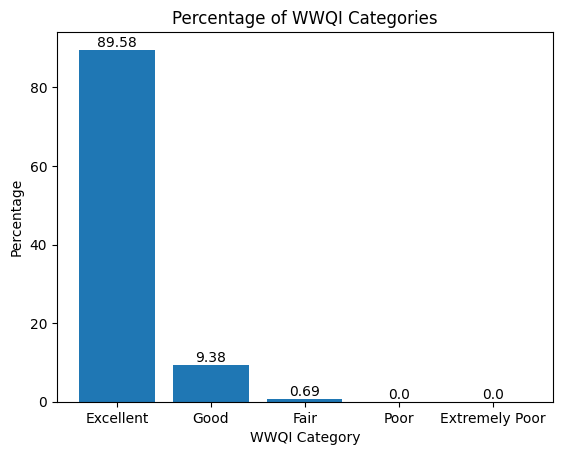

In [10]:
# Calculate WWQI categories
conditions = [
    (dfs['WWQIi'] < 25),
    (dfs['WWQIi'] >= 25) & (df['WWQIi'] < 50),
    (dfs['WWQIi'] >= 50) & (df['WWQIi'] < 75),
    (dfs['WWQIi'] >= 75) & (df['WWQIi'] < 100),
    (dfs['WWQIi'] >= 100)
]
categories = ['Excellent', 'Good', 'Fair', 'Poor', 'Extremely Poor']

# Create a new column 'WWQI_Category'
dfs['WWQI_Category'] = pd.cut(df['WWQIi'], bins=[-float('inf'), 25, 50, 75, 100, float('inf')],
                             labels=categories)

# Count occurrences of each category
category_counts = dfs['WWQI_Category'].value_counts()

# Calculate percentages
category_percentages = (category_counts / len(dfs)) * 100

fig, ax = plt.subplots()
bars = ax.bar(category_percentages.index, category_percentages.values)

# Display numbers above the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

plt.xlabel('WWQI Category')
plt.ylabel('Percentage')
plt.title('Percentage of WWQI Categories')
plt.show()

In [11]:
dfs.drop("WWQI_Category", axis=1, inplace=True)


In [12]:
dfs['Date'] = pd.to_datetime(dfs['Date'])
dfs.set_index('Date', inplace=True)

In [13]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dfs)

In [14]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []

    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        targets.append(label)

    return np.array(sequences), np.array(targets)

seq_length = 10  # You can adjust this based on your needs
X, y = create_sequences(scaled_data, seq_length)

In [15]:
def custom_train_test_split(X, y, test_size=0.2, random_state=None):
    classes = np.unique(y)
    train_indices, test_indices = [], []
    for c in classes:
        indices = np.where(y == c)[0]
        np.random.shuffle(indices)
        split_idx = int(len(indices) * (1 - test_size))
        train_indices.extend(indices[:split_idx])
        test_indices.extend(indices[split_idx:])
    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = custom_train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
X_train.shape

(1234, 10, 8)

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# RNN Modelling

In [17]:
modelRnn = Sequential()
modelRnn.add(SimpleRNN(units=16, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
modelRnn.add(SimpleRNN(units=64))
modelRnn.add(Dense(units=y_train.shape[1]))  # Assuming the output size is the same as input size

modelRnn.compile(optimizer='adam', loss='mean_squared_error')

historyRnn = modelRnn.fit(X_train, y_train, epochs=200, batch_size=24, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1694 - val_loss: 0.0336
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0266 - val_loss: 0.0281
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0246 - val_loss: 0.0260
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0220 - val_loss: 0.0246
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0203 - val_loss: 0.0257
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0208 - val_loss: 0.0245
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0214 - val_loss: 0.0230
Epoch 8/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0206 - val_loss: 0.0227
Epoch 9/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0191 - val_loss: 0.0236
Epoch 10/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0194 - val_loss: 0.0227
Epoch 11/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0190 - val_loss: 0.0220
Epoch 12/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0187 - val_l

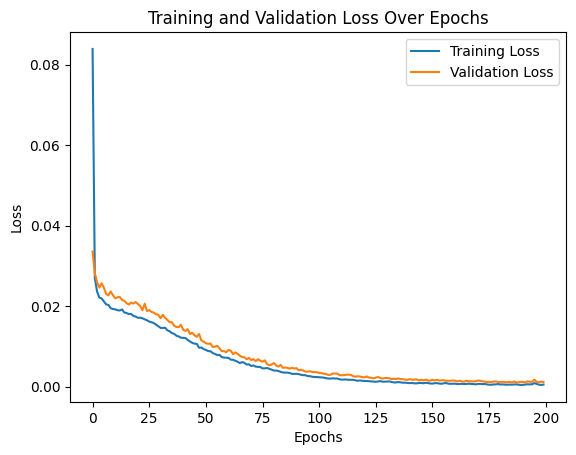

In [18]:
plt.plot(historyRnn.history['loss'], label='Training Loss')
# Plot validation loss
plt.plot(historyRnn.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [19]:
y_pred_scaled = modelRnn.predict(X_test)
y_pred_actual = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [20]:
actual_values = y_test_actual[:, 7]
predicted_values = y_pred_actual[:, 7]

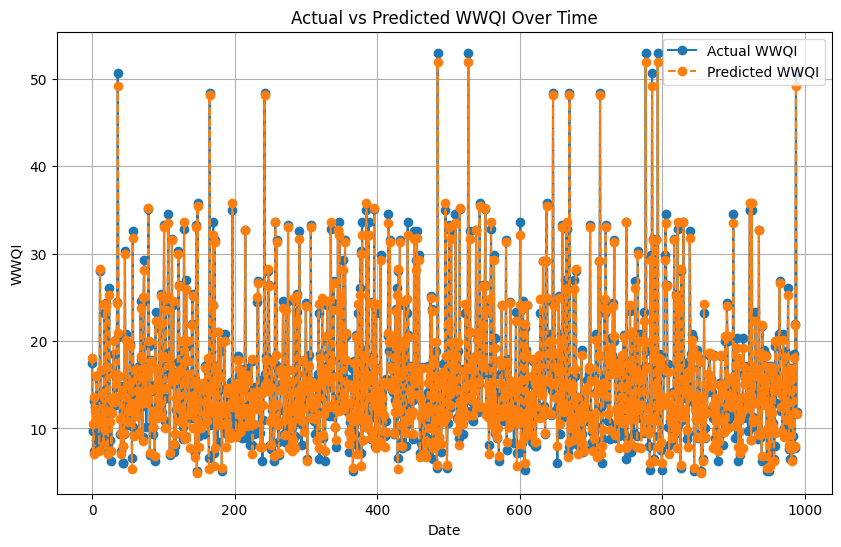

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual WWQI', marker='o')
plt.plot(predicted_values, label='Predicted WWQI', linestyle='dashed', marker='o')

plt.title('Actual vs Predicted WWQI Over Time')
plt.xlabel('Date')
plt.ylabel('WWQI')
plt.legend()
plt.grid(True)
plt.show()

In [24]:

# Calculate MAE and MSE
rnn_mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rnn_rmse = np.sqrt(mse)
r_squared_rnn = r2_score(actual_values, predicted_values)

print(f'Mean Absolute Error (MAE): {rnn_mae}')
print(f'Root Mean Squared Error (RMSE): {rnn_rmse}')
print("R-squared value:", r_squared_rnn)

Mean Absolute Error (MAE): 0.7502541925305234
Root Mean Squared Error (RMSE): 0.9846687854627356
R-squared value: 0.9844604460744509


In [25]:
future_steps_rnn = 120  # 10 years * 12 months

# Initial sequence to start prediction
initial_sequence_rnn = scaled_data[-seq_length:]

# Predict the future values
future_predictions_scaled_rnn = []

for _ in range(future_steps_rnn):
    next_pred_scaled_rnn = modelRnn.predict(initial_sequence_rnn.reshape(1, seq_length, scaled_data.shape[1]))
    future_predictions_scaled_rnn.append(next_pred_scaled_rnn)
    initial_sequence_rnn = np.concatenate((initial_sequence_rnn[1:], next_pred_scaled_rnn), axis=0)

# Convert the predictions to array
future_predictions_scaled_rnn = np.array(future_predictions_scaled_rnn).squeeze()

# Inverse transform the predictions to get them in the original scale
future_predictions_rnn = scaler.inverse_transform(future_predictions_scaled_rnn)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

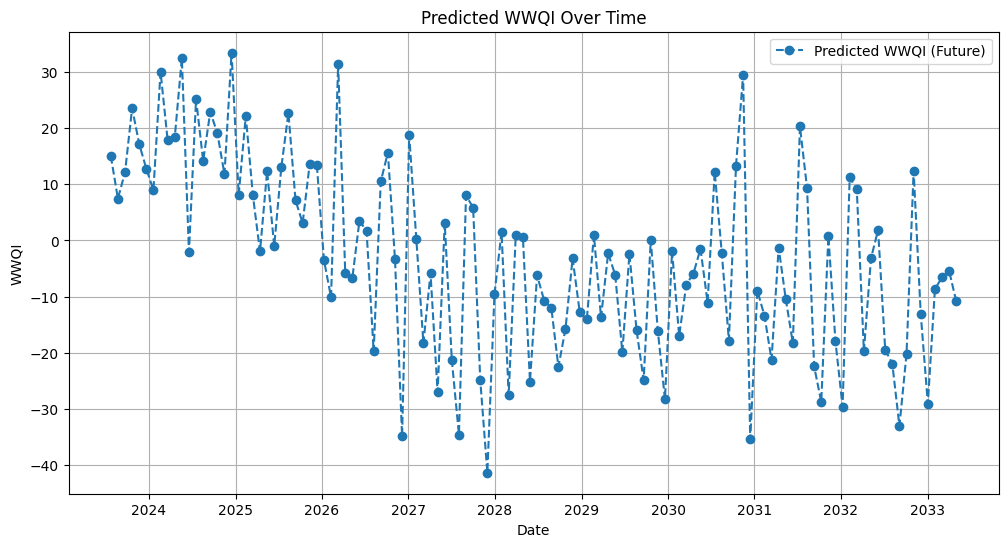

In [26]:
import datetime
last_date_rnn = dfs.index[-1]

# Generate future dates for the extended time series
future_dates_rnn = [last_date_rnn + datetime.timedelta(days=i * 30) for i in range(1, future_steps_rnn + 1)]

# Plot the predicted WWQI values for the future
plt.figure(figsize=(12, 6))
plt.plot(future_dates_rnn, future_predictions_rnn[:, 7], label='Predicted WWQI (Future)', linestyle='dashed', marker='o')

plt.title('Predicted WWQI Over Time')
plt.xlabel('Date')
plt.ylabel('WWQI')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
dfr = df.copy()

In [28]:
dfr = dfr.drop('WWQIs', axis=1)

In [29]:
dfr.head()

,Date,pH,Temp,TDS,TSS,Cl,BOD,COD,WWQIi
0,2021-07-02,7.6,30.0,316.0,18.0,76.0,1.5,33.6,13.65
1,2021-07-05,7.2,29.0,240.0,36.0,43.0,1.5,8.4,9.10
2,2021-07-07,7.3,30.0,276.0,21.0,51.0,0.8,16.8,9.28
3,2021-07-09,7.1,28.0,194.0,15.0,32.0,1.4,8.4,5.39
4,2021-07-12,7.5,29.0,198.0,16.0,36.0,1.1,8.4,10.00


In [30]:
dfr['Date'] = pd.to_datetime(dfr['Date'])
dfr.set_index('Date', inplace=True)

In [31]:
null_percentage = (dfr.isnull().sum() / len(dfr)) * 100
null_percentage

pH       0.347222
Temp     0.347222
TDS      0.347222
TSS      0.347222
Cl       0.347222
BOD      0.347222
COD      0.347222
WWQIi    0.347222
dtype: float64

In [32]:
for column in dfr.columns.difference(['Date']):
    mean_value = dfr[column].mean()
    dfr[column].fillna(mean_value, inplace=True)

/tmp/ipykernel_33/4147450775.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfr[column].fillna(mean_value, inplace=True)


In [33]:
null_percentage = (dfr.isnull().sum() / len(dfr)) * 100
null_percentage

pH       0.0
Temp     0.0
TDS      0.0
TSS      0.0
Cl       0.0
BOD      0.0
COD      0.0
WWQIi    0.0
dtype: float64

In [34]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dfr)

In [41]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []

    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        targets.append(label)

    return np.array(sequences), np.array(targets)

seq_length = 10  # You can adjust this based on your needs
X, y = create_sequences(scaled_data, seq_length)

In [42]:
X.shape

(278, 10, 8)

In [43]:
y.shape

(278, 8)

In [44]:
def custom_train_test_split(X, y, test_size=0.2, random_state=None):
    classes = np.unique(y)
    train_indices, test_indices = [], []
    for c in classes:
        indices = np.where(y == c)[0]
        np.random.shuffle(indices)
        split_idx = int(len(indices) * (1 - test_size))
        train_indices.extend(indices[:split_idx])
        test_indices.extend(indices[split_idx:])
    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = custom_train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
X_train.shape

(1234, 10, 8)

# LSTM Modelling

In [47]:
model1 = Sequential()
model1.add(LSTM(units=16, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model1.add(LSTM(units=64))

model1.add(Dense(units=scaled_data.shape[1])) # Assuming the output size is the same as input size

model1.compile(optimizer='adam', loss='mean_squared_error')

history1 = model1.fit(X_train_lstm, y_train_lstm, epochs=200, batch_size=24, validation_data=(X_test_lstm, y_test_lstm), verbose=1)

Epoch 1/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0518 - val_loss: 0.0277
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0236 - val_loss: 0.0263
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0215 - val_loss: 0.0252
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0208 - val_loss: 0.0257
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0211 - val_loss: 0.0247
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0205 - val_loss: 0.0244
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0209 - val_loss: 0.0241
Epoch 8/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0191 - val_loss: 0.0238
Epoch 9/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0199 - val_loss: 0.0240
Epoch 10/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0193 - val_loss: 0.0236
Epoch 11/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0198 - val_loss: 0.0237
Epoch 12/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

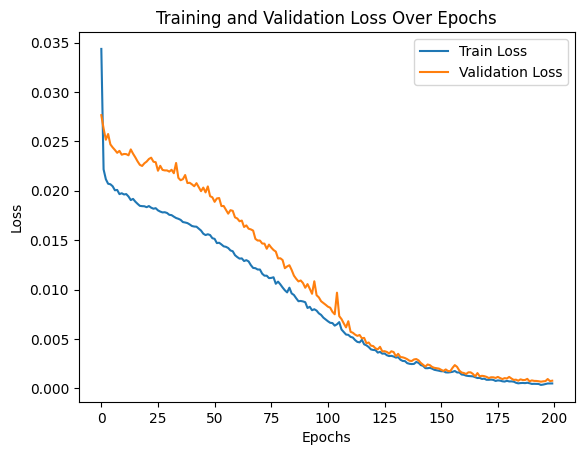

In [48]:
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [49]:
y_pred_scaled = model1.predict(X_test)
y_pred_actual = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [50]:
actual_values_lstm = y_test_actual[:, 7]
predicted_values_lstm = y_pred_actual[:, 7]

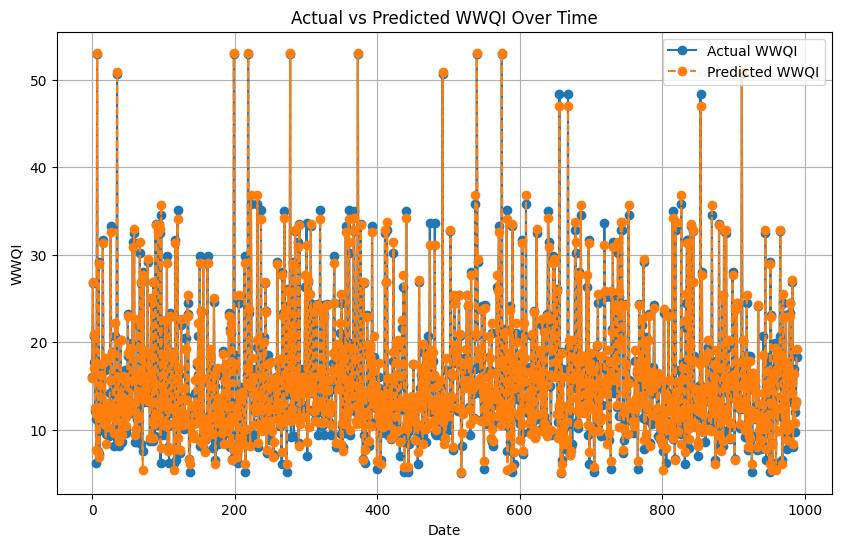

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(actual_values_lstm, label='Actual WWQI', marker='o')
plt.plot(predicted_values_lstm, label='Predicted WWQI', linestyle='dashed', marker='o')

plt.title('Actual vs Predicted WWQI Over Time')
plt.xlabel('Date')
plt.ylabel('WWQI')
plt.legend()
plt.grid(True)
plt.show()

In [52]:

# Calculate MAE and MSE
lstm_mae = mean_absolute_error(actual_values_lstm, predicted_values_lstm)
mse = mean_squared_error(actual_values_lstm, predicted_values_lstm)
lstm_rmse = np.sqrt(mse)
r_squared_lstm = r2_score(actual_values_lstm, predicted_values_lstm)

print(f'Mean Absolute Error (MAE): {lstm_mae}')
print(f'Root Mean Squared Error (RMSE): {lstm_rmse}')
print("R-squared value:", r_squared_lstm)

Mean Absolute Error (MAE): 0.7527528116679119
Root Mean Squared Error (RMSE): 1.0600869985501247
R-squared value: 0.9828037027096039


R-squared value: 0.9773361364682523


In [75]:
future_steps = 120  # 10 years * 12 months

# Initial sequence to start prediction
initial_sequence = scaled_data[-seq_length:]

# Predict the future values
future_predictions_scaled = []

for _ in range(future_steps):
    next_pred_scaled = model1.predict(initial_sequence.reshape(1, seq_length, scaled_data.shape[1]))
    future_predictions_scaled.append(next_pred_scaled)
    initial_sequence = np.concatenate((initial_sequence[1:], next_pred_scaled), axis=0)

# Convert the predictions to array
future_predictions_scaled = np.array(future_predictions_scaled).squeeze()

# Inverse transform the predictions to get them in the original scale
future_predictions = scaler.inverse_transform(future_predictions_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

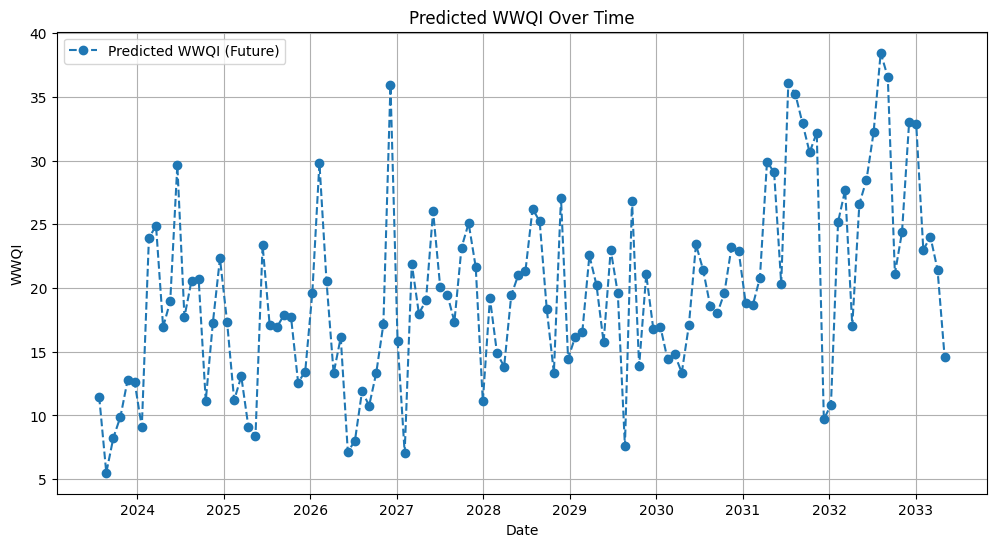

In [96]:
import datetime

# Assuming 'dfs' is your original DataFrame with 'Date' as index
last_date = dfr.index[-1]

# Generate future dates for the extended time series
future_dates = [last_date + datetime.timedelta(days=i * 30) for i in range(1, future_steps + 1)]

# Plot the predicted WWQI values for the future
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions[:, 7], label='Predicted WWQI (Future)', linestyle='dashed', marker='o')

plt.title('Predicted WWQI Over Time')
plt.xlabel('Date')
plt.ylabel('WWQI')
plt.legend()
plt.grid(True)
plt.show()


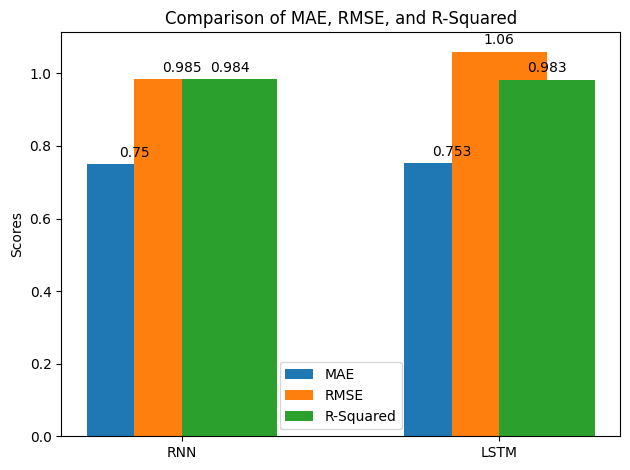

In [62]:
import numpy as np
import matplotlib.pyplot as plt

labels = ['RNN', 'LSTM']
mae_values = [round(rnn_mae, 3), round(lstm_mae, 3)]
rmse_values = [round(rnn_rmse, 3), round(lstm_rmse, 3)]
r2_values = [round(r_squared_rnn, 3), round(r_squared_lstm, 3)]
x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mae_values, width, label='MAE')
rects2 = ax.bar(x, rmse_values, width, label='RMSE')
rects3 = ax.bar(x + width/2, r2_values, width, label='R-Squared')

ax.set_ylabel('Scores')
ax.set_title('Comparison of MAE, RMSE, and R-Squared')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to add labels on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig('rnn_vs_lstm.png')
plt.show()


# WWQI Predictor

In [91]:
import numpy as np
import datetime

# Define the last date in your initial data
initial_year = 2023
initial_month = 4
initial_day = 6
initial_date = datetime.datetime(year=initial_year, month=initial_month, day=initial_day)
year = int(input("Enter the year: "))
month = int(input("Enter the month: "))
day = int(input("Enter the day: "))

# Define the target date
target_date = datetime.datetime(year=year, month=month, day=day)

# Find the index corresponding to the target date in the future dates list
delta_days = (target_date - last_date).days

# Calculate the index in the future predictions array
index = delta_days // 30  # Assuming each step in future_dates corresponds to 30 days

# Check if the index is within the range of available predictions
if 0 <= index < len(future_predictions):
    # Get the predicted value for the target date
    target_prediction = future_predictions[index, 7]  # Assuming you want the prediction for the 7th column
    print("Prediction for {}: {}".format(target_date.strftime("%Y-%m-%d"), target_prediction))
else:
    print("Prediction is not available for the given date.")

Enter the year:  2032
Enter the month:  1
Enter the day:  5


Prediction for 2032-01-05: 10.84066390991211
